> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/OPERA_GIS_Cloud.ipynb).

# Working with OPERA Dynamic Surface Water Extent (DSWx) Data:
## In AWS Cloud Version

#### *Author: Nicholas Tarpinian, PO.DAAC*

## Summary & Learning Objectives
#### Notebook showcasing how to work with OPERA DSWx data in the cloud
- Utilizing the earthaccess Python package. For more information visit: https://nsidc.github.io/earthaccess/
- Option to query the new dataset based on users choice; either by classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR'), etc.
- Visualizing the dataset based on its classified layer values.
- Mosaicking multiple layers into a single layer.
- Utilizing Change Detection for further analysis.

## Requirements

### 1. Compute environment 

This tutorial can only be run in the following environment:
- **AWS instance running in us-west-2**: NASA Earthdata Cloud data in S3 can be directly accessed via and s3fs session; this access is limited to requests made within the US West (Oregon) (code: `us-west-2`) AWS region.

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### Import Packages

In [1]:
import os
import requests 
import json
import boto3
import s3fs
from osgeo import gdal
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
from json import dumps
import earthaccess
from earthaccess import Auth, DataCollections, DataGranules, Store

## Authentication with `earthaccess`

In this notebook, we will be calling the authentication in the below cell.

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True)

## Set up an s3fs session for Direct Access
s3fs sessions are used for authenticated access to s3 bucket and allows for typical file-system style operations. Below we create session by passing in the data provider.

In [3]:
fs_s3 = Store(auth).get_s3fs_session(daac="PODAAC", provider="POCLOUD")

## Search Using `earthaccess` for OPERA DSWx
Each dataset has it's own unique collection ID. For the OPERA_L3_DSWX-HLS_V1 dataset, we can find the collection ID [here](https://podaac.jpl.nasa.gov/dataset/OPERA_L3_DSWX-HLS_V1).

For this tutorial, we are looking at the Lake Powell Reservoir.

We used [bbox finder](http://bboxfinder.com/) to get the exact coordinates for our area of interest.

We want to look at two different times for comparison: 04/11/2023 and 08/30/2023. To find these dates, let's search for all the data granules between the two. 

Finding 08/30/23 you must search a couple days after at 09/01/23 for when the product was generated for 08/30/23.

In [4]:
#search for the granules using the short name
opera_results = earthaccess.search_data(short_name="OPERA_L3_DSWX-HLS_V1", temporal= ("2023-04-11","2023-09-01"), bounding_box = ('-111.144811','36.980121','-110.250799','37.915625'))

Granules found: 310


### Get S3 Bucket links from search results

Because we are working within the AWS cloud, let's get the S3 bucket links for the 8 desired files. We want to query the dataset based on a specific classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR').

OPERA has 10 different available layers. We will look at 'B01_WTR' which is the Water Classification (WTR) layer of the OPERA DSWx dataset. Details on each available layer and the data product can be found [here](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DSWX_URS309746.pdf).

In [5]:
#add the S3 bucket links to lists, here we are looking for B01_WTR layer and two dates specified earlier
april = []
august = []
for g in opera_results:
    for l in earthaccess.results.DataGranule.data_links(g, access='direct'):
        if 'B01_WTR' in l: 
            if '20230411' in l:
                april.append(l)
            if '20230830' in l:
                august.append(l)

print(len(april))
print(len(august))

4
4


## Visualizing the Dataset

Let's now visualize an individual layer for a single file that was downloaded using Rasterio to read the GeoTIFF image.

In [6]:
s3_url = april[2]

In [7]:
s3_file_obj1 = fs_s3.open(s3_url, mode='rb')

In [8]:
dsw = rio.open(s3_file_obj1)
dsw

<open DatasetReader name='/vsipythonfilelike/5f942afb-36e7-448e-8456-360c9ae94618/5f942afb-36e7-448e-8456-360c9ae94618' mode='r'>

OPERA is a single band image with specific classified rgb values.

This requires to read the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [9]:
image = dsw.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw2 = color_array[image]

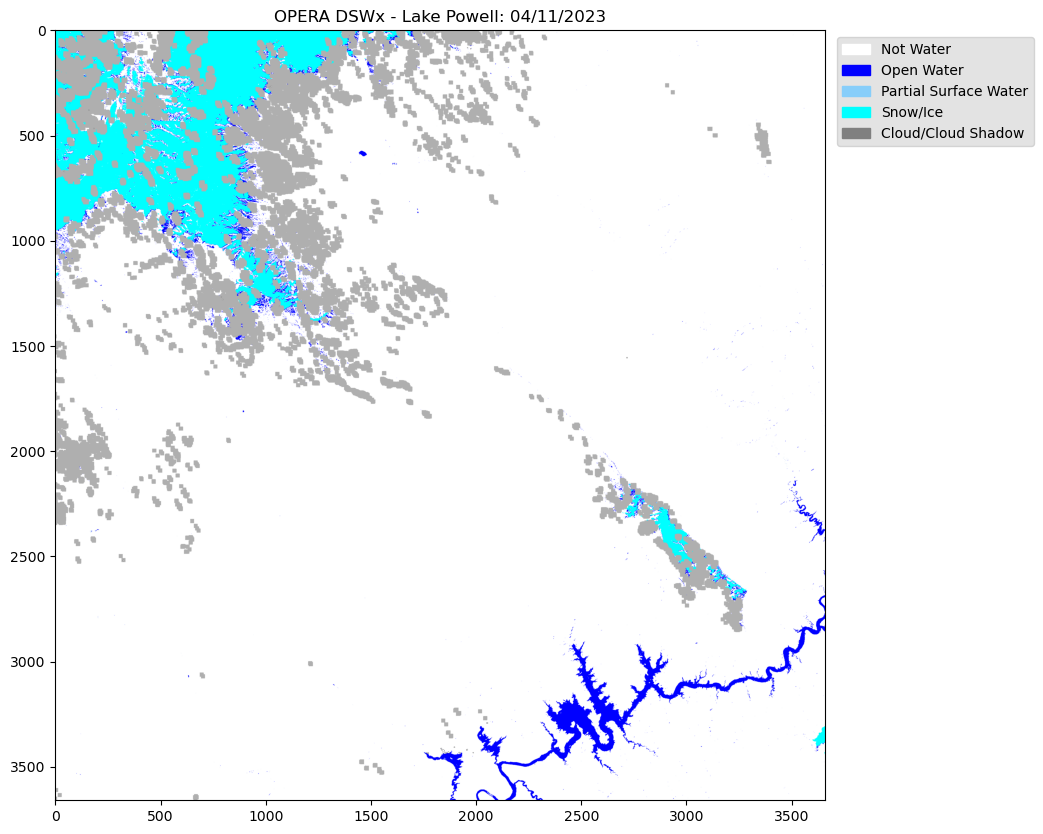

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches,
          bbox_to_anchor=(1.28, 1),
          facecolor="gainsboro")

plt.imshow(dsw2)
plt.show()

## Mosaic Multiple OPERA Layers

When creating a mosaic, make sure the temporal range is correct/matching.

The mosaic is being created because we have 4 results from the bounding box area provided. If you receive more than 1 result and would like to see a single raster image of all the results, mosaicking is the solution. We define the function below to merge the tiff files for each date and return the composite raster into memory.

In [11]:
def raster2mosaic(date):
    datasets = []
    for file in date:
        file_path = f"{file}"
        file_obj = fs_s3.open(file_path)
        dataset = rio.open(file_obj)
        datasets.append(dataset)
    mosaic, output = merge(datasets) #the merge function will mosaic the raster images
    
    #Saving the output of the mosaicked raster image to memory
    memfile = MemoryFile()
    with memfile.open(driver='GTiff', count = 1, width= mosaic.shape[1], height=mosaic.shape[2] , dtype=np.uint8, transform=output) as dst:
        dst.write(mosaic)
    mosaic_bytes = memfile.read()
    with MemoryFile(mosaic_bytes) as memfile:
        dataset1 = memfile.open()
        raster = dataset1.read(1)
    return raster

In [12]:
aprilmos = raster2mosaic(april)
augustmos = raster2mosaic(august)

## Visualizing the Mosaic
To visualize the mosaic, you must utilize the single layer colormap.

This will be the 'dsw' variable used earlier to visualize a single layer. Similarly reading the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [13]:
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw3 = color_array[aprilmos]

In [14]:
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw4 = color_array[augustmos]

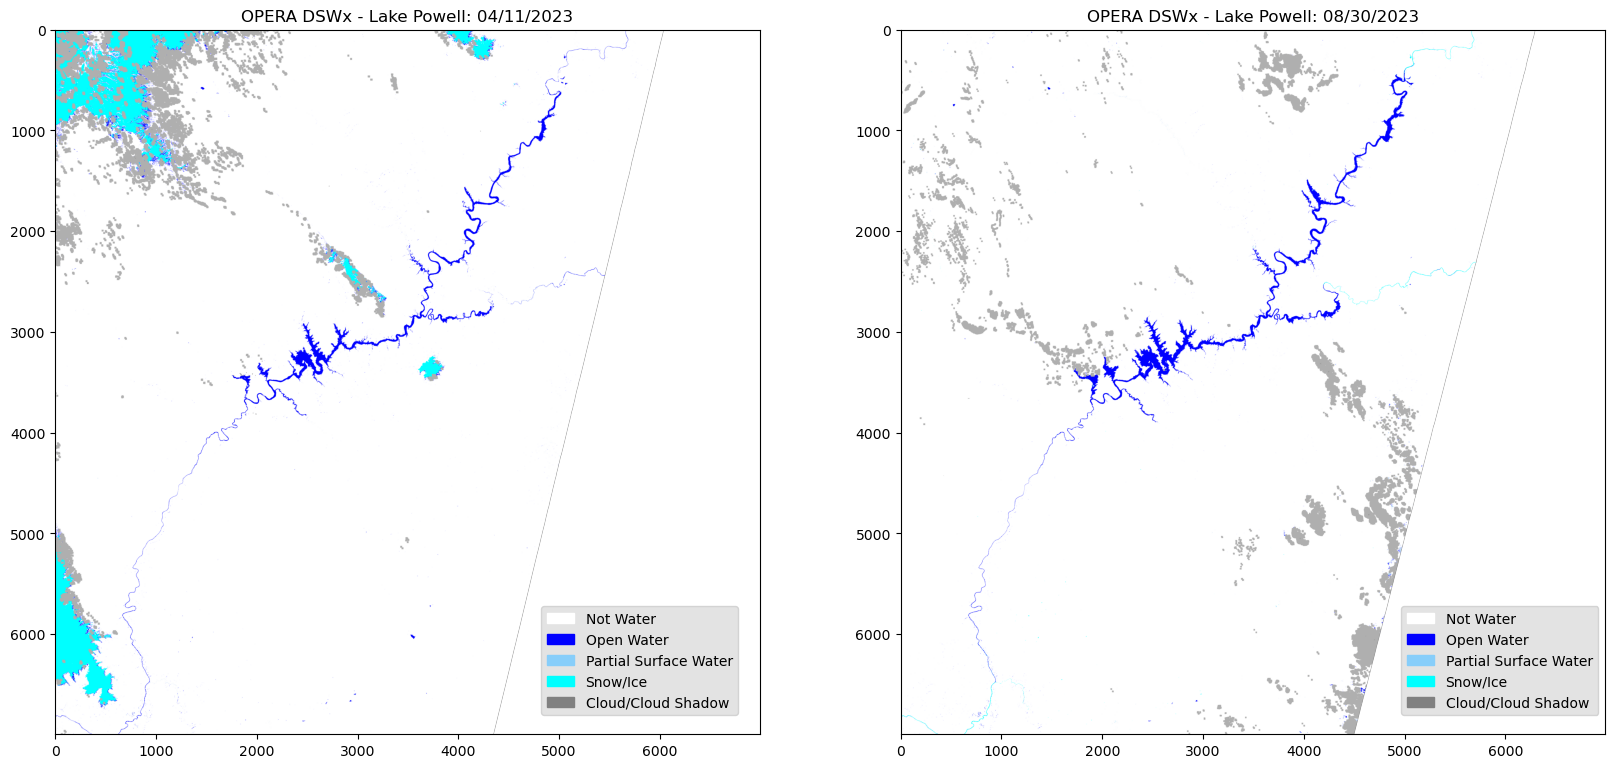

In [15]:
fig = plt.figure(figsize=(20, 15))

rows = 1
columns = 2

# Lake Powell 04/11/2023
fig.add_subplot(rows, columns, 1)
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")
plt.imshow(dsw3)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.47,0.35),
        facecolor="gainsboro")

# Lake Powell 08/30/2023
fig.add_subplot(rows, columns, 2)
plt.title("OPERA DSWx - Lake Powell: 08/30/2023")
plt.imshow(dsw4)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.9, 0.35),
        facecolor="gainsboro")

plt.show()

### To take a closer look at a specific area of the image, we can create an inset map of a specified area.

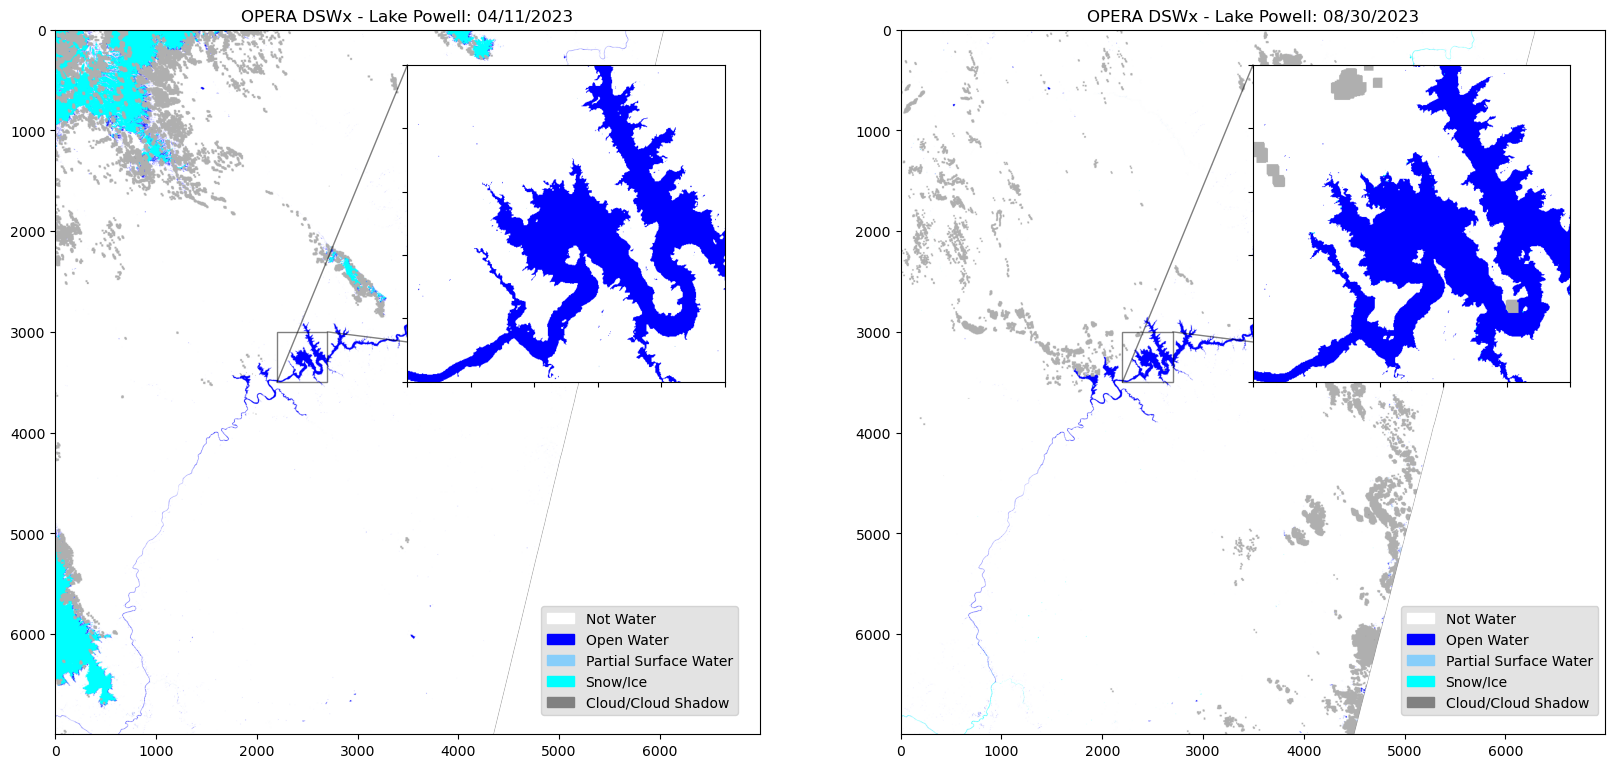

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(dsw3)
ax[0].set_title("OPERA DSWx - Lake Powell: 04/11/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.47,0.35),
          facecolor="gainsboro")

ax_ins1 = ax[0].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins1.imshow(dsw3)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins1.set_xlim(x1, x2)
ax_ins1.set_ylim(y1, y2)
ax_ins1.set_xticklabels('')
ax_ins1.set_yticklabels('')

ax[0].indicate_inset_zoom(ax_ins1, edgecolor='black')

ax[1].imshow(dsw4)
ax[1].set_title("OPERA DSWx - Lake Powell: 08/30/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.9, 0.35),
          facecolor="gainsboro")

ax_ins2 = ax[1].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins2.imshow(dsw4)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins2.set_xlim(x1, x2)
ax_ins2.set_ylim(y1, y2)
ax_ins2.set_xticklabels('')
ax_ins2.set_yticklabels('')

ax[1].indicate_inset_zoom(ax_ins2, edgecolor='black')

plt.show()

### Change Detection

Further analysis can involve change detection between the two images, if any gains or losses occurred.

Looking at the difference by subtracting the latest date to the oldest date.

In [17]:
difference = np.abs(augustmos - aprilmos)

Utilizing numpy where; by setting the given condition and returning the satisfied conditions. e.g. numpy.where(condition, [x, y, ])

In this case, any non-zero values indicate the areas of change between the two images.

Values closest to 1 shows the greatest gains in change and values closest to zero show the least amount of change.

In [18]:
change_map = np.where(difference > 0, 1, 0)

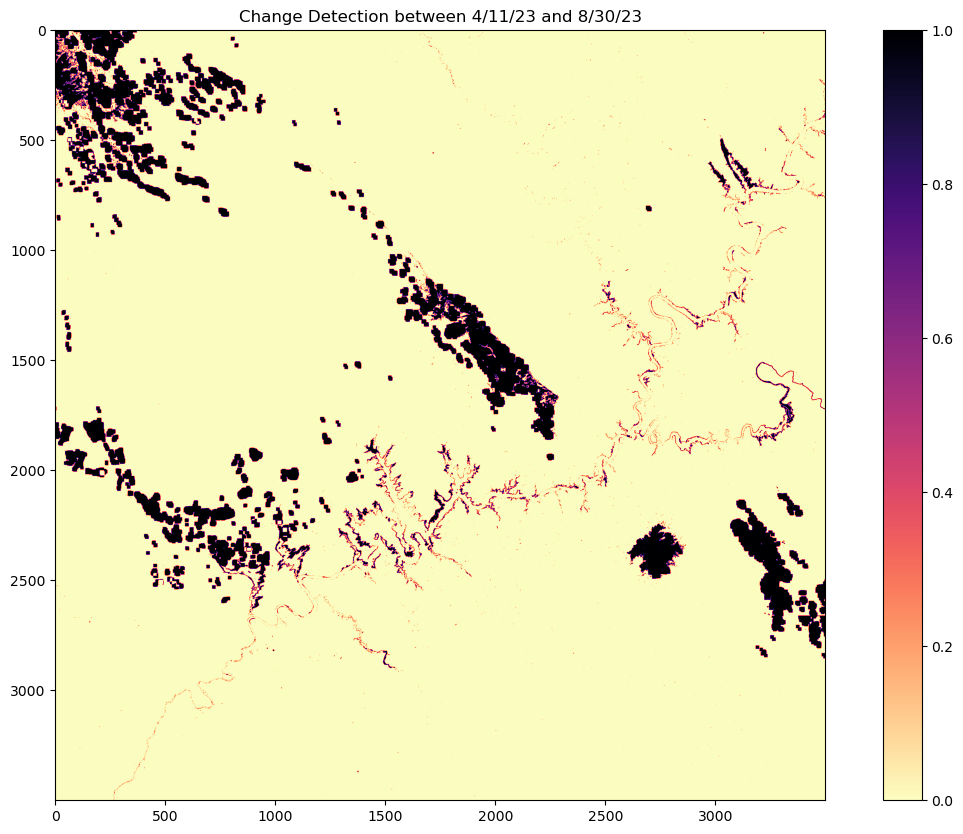

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

# Defining and zooming into an ROI
x1, y1, x2, y2 = 1000, 1000, 4500, 4500
roi = change_map[y1:y2, x1:x2]

# Inversing the colormap
original_cmap = plt.get_cmap('magma')
reversed_cmap = original_cmap.reversed()

plt.imshow(roi, cmap=reversed_cmap)
plt.colorbar()
plt.title('Change Detection between 4/11/23 and 8/30/23')

plt.show()